<h1><center> Assignment 4 </center> </h1>

<h2 style="text-align:left;">
    Name: Sushovan Jena
    <span style="float:right;">
        Course: CS669
    </span>
</h2>
<h2 style="text-align:left;">
    Enroll No.: S20011
    <span style="float:right;">
         (Pattern Recognition)
    </span>
</h2>


<h1>Implementation of MultiLayer Perceptron (MLP) Neural Network</h1> 

In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

### Activation Functions Definitions
class Sigmoid():
    def __call__(self, x, b=1):
        return 1.0/(1.0 + np.exp(-(b*x)))
    def gradient(self, x, b=1):
        return self.__call__(x, b) * (1 - self.__call__(x, b))

class Linear():
    def __call__(self, x, b=1):
        return b*x
    def gradient(self, x, b=1):
        return b

### Multilayer feed forward neural network class
class MLP():
    def __init__(self, n_hidden, n_epoch=1000, learning_rate=0.01, threshold=0.001):
        self.n_hidden = n_hidden
        self.n_epoch = n_epoch
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.hidden_activation = Sigmoid()
        self.output_activation = Sigmoid()

    ### Initialize the weights of neural network
    def initialize_weights(self, X, y):
        n_samples, n_features = X.shape
        _, n_outputs = y.shape
        
        ### For all hidden layers
        pre_num_of_neuron = n_features
        self.weights = {}
        self.w0 = {}
        for i in range(len(self.n_hidden)):
            limit   = 1 / math.sqrt(pre_num_of_neuron/2)
            np.random.seed(100)
            self.weights[i]  = np.random.uniform(-limit, limit, (pre_num_of_neuron, self.n_hidden[i]))
            self.w0[i] = np.zeros((1, self.n_hidden[i]))
            pre_num_of_neuron = self.n_hidden[i]
        
        # For output layer
        limit   = 1 / math.sqrt(pre_num_of_neuron/2)
        np.random.seed(100)
        self.V  = np.random.uniform(-limit, limit, (self.n_hidden[-1], n_outputs))
        self.v0 = np.zeros((1, n_outputs))

    ### To train the model
    def train(self, X, y, epoch=True):
        self.initialize_weights(X, y)
        self.errors = []
        ### This conditional block of code is for fixed number of epoch
        if epoch == True:
            ### Run it for n_epoch times
            for i in range(self.n_epoch):
                ### For hidden layer
                inputs = X
                self.hidden_input = {}
                self.hidden_output = {}
                ### Forward Calculation ###
                self.forward_calculation(inputs)
                ### Backpropagation Calculation ###
                self.backpropagation_calculation(inputs, y)

                ### Store average instantaneous errors for each epoch
                self.errors.append(np.sum(self.SquareLoss(y, self.y_pred))/y.shape[0])
        ### This conditional block of code is for fixed threshold of average error
        else:
            error = 10000000
            noOfNoChangeError = 0
            ### Run it until error converges to the threshhold
            while error > self.threshold:
                ### For hidden layer
                inputs = X
                self.hidden_input = {}
                self.hidden_output = {}
                ### Forward Calculation ###
                self.forward_calculation(inputs)
                ### Backpropagation Calculation ###
                self.backpropagation_calculation(inputs, y)
                
                ### Store average instantaneous errors for each epoch
                self.errors.append(np.sum(self.SquareLoss(y, self.y_pred))/y.shape[0])
                ### If there is no change in error
                if noOfNoChangeError >=20:
                    break
                else:
                    if len(self.errors) >= 4:
                        if error == self.errors[-1] and error == self.errors[-2]:
                            noOfNoChangeError += 1
                error = self.errors[-1]
                
    ### Forward Calculation ###
    def forward_calculation(self, inputs):
        ### For hidden layer
        for i in range(len(self.n_hidden)):
            ### Input to neuron
            self.hidden_input[i] = inputs.dot(self.weights[i]) + self.w0[i]
            ### Output of neuron
            self.hidden_output[i] = self.hidden_activation(self.hidden_input[i])
            inputs = self.hidden_output[i]
        ### For output layer
        self.output_layer_input = inputs.dot(self.V) + self.v0
        self.y_pred = self.output_activation(self.output_layer_input)
        return self.y_pred
    
    ### Backpropagation Calculation ###
    def backpropagation_calculation(self, inputs, y):
        ### First for output layer
        ### Gradient w.r.t input of output layer
        grad_wrt_out_l_input = self.loss(y, self.y_pred) * self.output_activation.gradient(self.output_layer_input)
        grad_v = self.hidden_output[len(self.n_hidden)-1].T.dot(grad_wrt_out_l_input)
        grad_v0 = np.sum(grad_wrt_out_l_input, axis=0, keepdims=True)
        ### For hidden layer
        ### Gradient w.r.t input of hidden layer
        next_grad_wrt_hidden_l_input = grad_wrt_out_l_input
        next_weight = self.V
        prev_input = inputs
        grad_w = {}
        grad_w0 = {}
        ### Calculation for multiple hidden layer starting from last to first hidden layer
        for i in reversed(range(len(self.n_hidden))):
            grad_wrt_hidden_l_input = next_grad_wrt_hidden_l_input.dot(next_weight.T) * self.hidden_activation.gradient(self.hidden_input[i])
            ### If hidden layer not connected to input layer
            if i != 0:
                grad_w[i] = self.hidden_output[i-1].T.dot(grad_wrt_hidden_l_input)
            ### when hidden layer connected to input layer
            else:
                grad_w[i] = inputs.T.dot(grad_wrt_hidden_l_input)
            grad_w0[i] = np.sum(grad_wrt_hidden_l_input, axis=0, keepdims=True)
            next_grad_wrt_hidden_l_input = grad_wrt_hidden_l_input
            next_weight = self.weights[i]

        ### Calculaton for weights update ###
        ### Weights update of output layer
        self.V  -= self.learning_rate * grad_v
        self.v0 -= self.learning_rate * grad_v0
        ### Weights update of hidden layers
        for i in range(len(self.n_hidden)):
            self.weights[i]  -= self.learning_rate * grad_w[i]
            self.w0[i] -= self.learning_rate * grad_w0[i]
    
    ### Prediction Function
    def predict(self, X):
        ### Call Forward Calculation ###
        y_pred = self.forward_calculation(X)
        return y_pred
    
    ### Instantaneous error and loss function
    def SquareLoss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)
    def loss(self, y, y_pred):
        return -(y - y_pred)

### Calculate the accuracy
def accuracy_score(y, y_pred):
    accuracy = np.sum(y == y_pred, axis=0) / len(y)
    return accuracy*100

### To calculate the confusion matrix and classification accuracy
def confusion_matrix(actual, predicted):
    n_label = len(np.unique(actual))
    cm = np.zeros((n_label, n_label))
    for i, j in zip(actual, predicted):
        cm[i][j] += 1
    ### For classification accuracy
    accuracy = np.sum(actual == predicted) * 100.0 / float(len(actual))
    return cm, accuracy

### Plot of Epoch vs Mean Square Error
def epochVsError_plot(model):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    error = model.errors
    nepoch = [i+1 for i in range(len(error))]
    plt.scatter(nepoch, error, marker='o', s=5, facecolors='b', edgecolors='b')
    plt.xlabel('Number of Epoch')
    plt.ylabel('Average Error')
#     plt.title('Average error vs number of epoch for training of Non-Linearly Seperable data using MLP')
    plt.savefig("AvgErrorVsEpoch_MLP.png", dpi=300, bbox_inches="tight")
    plt.show()

### Decision Region Plot
def decision_boundary_plot(testX, test1, test2, model):
    ### Get the minimum and maximum limit for x-axis and y-axis from data
    x_min, x_max = testX[:, 0].min() - 1, testX[:, 0].max() + 1
    y_min, y_max = testX[:, 1].min() - 1, testX[:, 1].max() + 1
#     print(x_min, x_max, y_min, y_max)
    ### Create the data points from x-axis and y-axis values with some intervals
    h=0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    g_data = np.c_[xx.ravel(), yy.ravel()]
    
    ### prediction of created data points
    predictedLabel = np.argmax(model.predict(g_data), axis=1)
    colors = ['#EE6363', '#BCEE68', '#B2DFEE']
    predictedColor = [colors[i] for i in predictedLabel]
    
    ### Plot input test data and decision region 
    plt.scatter(g_data[:,0], g_data[:,1], s=5, color=predictedColor)
    plt.scatter(np.array(test1)[:,0], np.array(test1)[:,1], s=5, color='red', label='Class1')
    plt.scatter(np.array(test2)[:,0], np.array(test2)[:,1], s=5, color='green', label='Class2')
#     plt.scatter(np.array(test3)[:,0], np.array(test3)[:,1], s=5, color='blue', label='Class3')
    plt.legend(bbox_to_anchor=(0.05, 1.15), loc='upper left', ncol=3)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.savefig("decision_boundry_MLP.png", dpi=300, bbox_inches="tight")
    plt.show()

### Create data set by combining the two class data
def two_class_data(train1, train2, test1, test2):
    trainX = np.concatenate((train1, train2), axis=0)
    trainY = np.array([0 for i in range(len(train1))] + [1 for i in range(len(train2))])
    testX = np.concatenate((test1, test2), axis=0)
    testY = np.array([0 for i in range(len(test1))] + [1 for i in range(len(test2))])
    return trainX, trainY, testX, testY


<h1>Read the non-linearly seperable dataset files and perform the training and testing using MLP</h1>

Confusion Matrix of Test Data: [[300.   0.]
 [  0. 300.]]

Classification Accuracy of Test Data: 100.0

Final Avg. Error: 0.000474819405944066, Epoch: 5000



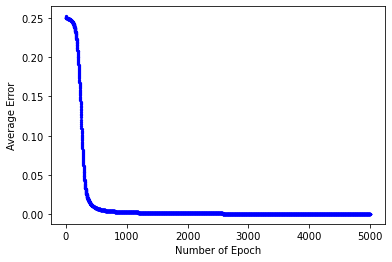

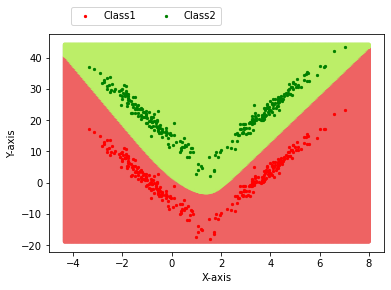

In [2]:
#### Path of all class dataset 
f1 = r"D:/Sujeet_PhD/Course_Work/Pattern Recognition/Assignment/Assignment_04/nls_data/class1.txt"
f2 = r"D:/Sujeet_PhD/Course_Work/Pattern Recognition/Assignment/Assignment_04/nls_data/class2.txt"

### Devide the Class1 data into training and testing data
df = pd.read_csv(f1, header=None)
train1 = df.sample(frac=0.70, random_state=100)
test1 = df[~df.index.isin(train1.index)]
### Devide the Class2 data into training, validation, and testing data
df = pd.read_csv(f2, header=None)
train2 = df.sample(frac=0.70, random_state=100)
test2 = df[~df.index.isin(train2.index)]

#### For classification between Class1 and Class2 ####
trainX, trainY, testX, testY = two_class_data(train1, train2, test1, test2)

### Convert label data to one hot encoder
### 0 -> (1, 0), 1 -> (0, 1)
enc = OneHotEncoder()
y_OHE_train = enc.fit_transform(np.expand_dims(trainY,1)).toarray()
y_OHE_test = enc.fit_transform(np.expand_dims(testY,1)).toarray()

def main():
    ### Setting the parameters
    hsize, n_ep, lr, th, ep_status = [2, 4, 2], 5000, 0.001, 0.0001, True
    ### Call the MLP calss 
    mlp = MLP(n_hidden=hsize, n_epoch=n_ep, learning_rate=lr, threshold=th)
    ### Train the MLP
    mlp.train(trainX, y_OHE_train, epoch=ep_status)
    
    ### Prediction for test data
    y_pred_test = np.argmax(mlp.predict(testX), axis=1)
    y_test = np.argmax(y_OHE_test, axis=1)

    ### Call the confusion_matrix function
    CM, Accuracy = confusion_matrix(y_test, y_pred_test)
    
    print("Confusion Matrix of Test Data: {}\n".format(CM))
    print("Classification Accuracy of Test Data: {}\n".format(Accuracy))
    print("Final Avg. Error: {}, Epoch: {}\n".format(mlp.errors[-1], len(mlp.errors)))

    ### Epoch vs error plot
    epochVsError_plot(mlp)
    
    ### Decision boundary plot
    decision_boundary_plot(testX, test1, test2, mlp)

if __name__ == "__main__":
    main()

<h1>Read the linearly seperable dataset files and perform the training and testing using MLP</h1>

Confusion Matrix of Test Data: [[300.   0.]
 [  0. 300.]]

Classification Accuracy of Test Data: 100.0

Final Avg. Error: 8.66469721255388e-05, Epoch: 5000



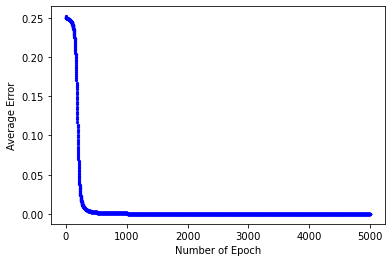

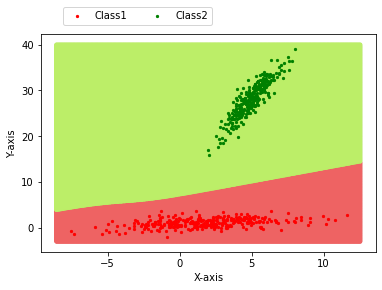

In [3]:
#### Path of all class dataset 
f1 = r"D:/Sujeet_PhD/Course_Work/Pattern Recognition/Assignment/Assignment_04/ls_data/class1.txt"
f2 = r"D:/Sujeet_PhD/Course_Work/Pattern Recognition/Assignment/Assignment_04/ls_data/class2.txt"

### Devide the Class1 data into training and testing data
df = pd.read_csv(f1, header=None)
train1 = df.sample(frac=0.70, random_state=100)
test1 = df[~df.index.isin(train1.index)]
### Devide the Class2 data into training, validation, and testing data
df = pd.read_csv(f2, header=None)
train2 = df.sample(frac=0.70, random_state=100)
test2 = df[~df.index.isin(train2.index)]

#### For classification between Class1 and Class2 ####
trainX, trainY, testX, testY = two_class_data(train1, train2, test1, test2)

### Convert label data to one hot encoder
### 0 -> (1, 0), 1 -> (0, 1)
enc = OneHotEncoder()
y_OHE_train = enc.fit_transform(np.expand_dims(trainY,1)).toarray()
y_OHE_test = enc.fit_transform(np.expand_dims(testY,1)).toarray()

def main():
    ### Setting the parameters
    hsize, n_ep, lr, th, ep_status = [4, 8, 4], 5000, 0.001, 0.0001, True
    ### Call the MLP calss 
    mlp = MLP(n_hidden=hsize, n_epoch=n_ep, learning_rate=lr, threshold=th)
    ### Train the MLP
    mlp.train(trainX, y_OHE_train, epoch=ep_status)
    
    ### Prediction for test data
    y_pred_test = np.argmax(mlp.predict(testX), axis=1)
    y_test = np.argmax(y_OHE_test, axis=1)

    ### Call the confusion_matrix function
    CM, Accuracy = confusion_matrix(y_test, y_pred_test)
    
    print("Confusion Matrix of Test Data: {}\n".format(CM))
    print("Classification Accuracy of Test Data: {}\n".format(Accuracy))
    print("Final Avg. Error: {}, Epoch: {}\n".format(mlp.errors[-1], len(mlp.errors)))

    ### Epoch vs error plot
    epochVsError_plot(mlp)
    
    ### Decision boundary plot
    decision_boundary_plot(testX, test1, test2, mlp)

if __name__ == "__main__":
    main()